## Setup

In [1]:
# Import the packages
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
from sklearn.metrics import r2_score
from sqlalchemy import create_engine


In [2]:
plt.style.use('dark_background')
#resize plot to wide form
plt.rcParams['figure.figsize'] = [20, 4]
#shrink plot labels
plt.rcParams.update({'font.size': 12})
#remove all boundaries
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [3]:
def bulk_insert(df, table_name, conn_string):
    conn = psycopg2.connect(conn_string)
    cur = conn.cursor()
    output = io.StringIO()
    df.to_csv(output, sep='\t', header=False, index=True)
    output.seek(0)
    cur.copy_from(output,table_name, null="")
    conn.commit()
    conn.close()


## Inputs

In [5]:
# input_table = '/Users/walterzesk/Documents/repos/growing_lslands/littoral/toy_island/island_cycle.csv'
# table_name = 'island_cycle'

input_table = '/Users/walterzesk/postgressql_prediction/tspdb-isl/notebooks/island_banyan.csv'
table_name = 'island_banyan'

smoothing = 3

## Read Table

In [6]:
#read data
data_raw = pd.read_csv(input_table, delimiter = ',')

#get data_raw length
data_raw_length = len(data_raw)

#get split index for train and test
split_index = int(data_raw_length*.8)
split_index, data_raw_length

#set datatype to datetime for first column in data_raw
data_raw['time'] = pd.to_datetime(data_raw['time'])
data_raw.set_index('time', inplace=True)

In [7]:
#smooth data (averaging small cyclical changes like tide)
sm_len = smoothing
data_raw_sm = data_raw.rolling(sm_len).mean()

#split data into train and test
data_train = data_raw_sm.iloc[:(split_index)]
data_test = data_raw_sm.iloc[(split_index):]

print(data_train.shape)

(1728, 20)


## DB connection

In [8]:
## fill your db information
database = '' # FILL IN your db name where tspdb is installed
user = 'postgres' #  FILL IN  user name here
password = '00' #  # FILL IN  password here
host = 'localhost' #  # FILL IN  host name
conn_string = "host='%s' dbname='%s' user='%s' password='%s'" %(host, database, user, password)
driver="postgresql"
engine = create_engine(driver + '://' + user + ':' + password + '@' + host + '/' + database)

## Create Time Series Table

In [9]:
conn = psycopg2.connect(conn_string)

cur = conn.cursor()

# Drop the table if it already exists
cur.execute("DROP table IF EXISTS "+table_name+";")
conn.commit()
conn.close()

# load data into Pandas dataframe
data_train.to_sql(table_name, engine, index=True, index_label='time')
#data_train.to_csv(table_name+'.csv')#save table to csv if needed

print('Table created and Loaded')

Table created and Loaded


In [10]:
# lets query our table to inspect its column 
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from "+table_name+" order by time DESC limit 10;", conn)
conn.close()
#df

/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_85160/654331706.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("select * from "+table_name+" order by time DESC limit 10;", conn)


## Create prediction index

In [11]:
# get all columns and format it
cols = '{"'+'","'.join(data_train.columns[:])+'"}'
pred_table_name = 'pindex_'+table_name
query = """select create_pindex('%s', 'time','%s','%s', k=> 20);"""%(table_name, cols, pred_table_name)
# print('formated query : ',query )

conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute(query)
conn.commit()
conn.close()

In [12]:
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from list_pindices()", conn)
#df

/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_85160/2197704022.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("select * from list_pindices()", conn)


## Prediction Queries

In [13]:
#get date from the last row of the test data
start_pred = str(data_test.iloc[0].name)
end_pred = str(data_test.iloc[len(data_test)-1].name)

#get column names for data_test
col1 = data_test.columns[1]

#subtract start_pred from end_pred and convert result to days
pred_days = (pd.to_datetime(end_pred) - pd.to_datetime(start_pred)).days


/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_85160/2743019938.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('''select * from predict('%s','%s','%s'\


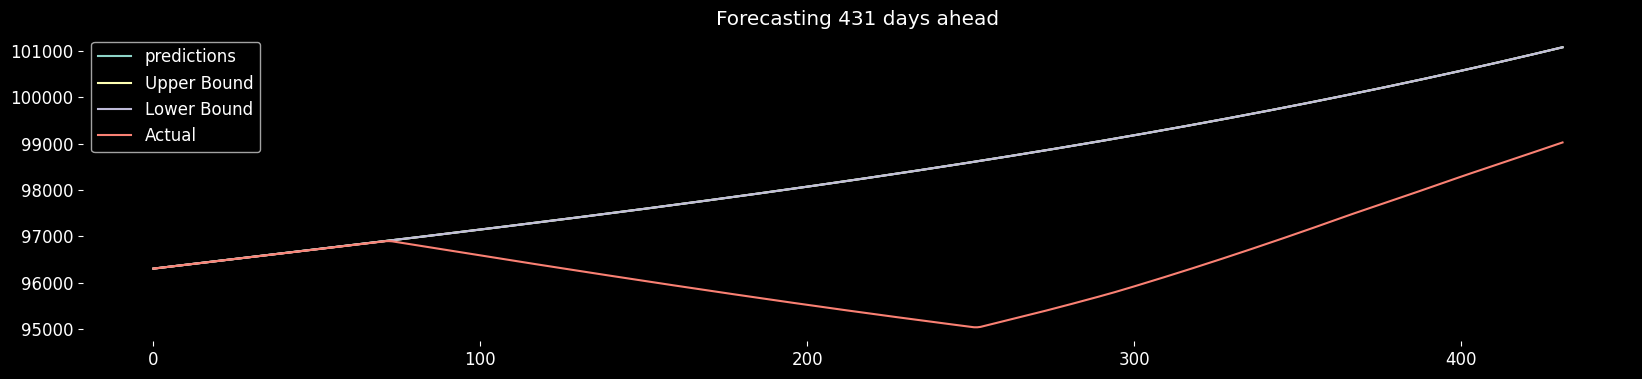

In [14]:
%matplotlib inline
df = pd.read_sql_query('''select * from predict('%s','%s','%s'\
,'%s','%s');'''%(table_name,col1,start_pred,end_pred,pred_table_name), conn)

plt.figure()
plt.plot( df['prediction'], label = 'predictions')
plt.plot( df['ub'], label = 'Upper Bound')
plt.plot(df['lb'], label = 'Lower Bound')
plt.plot(data_test[col1].values[:len(df['prediction'])], label = 'Actual')
plt.title('Forecasting %s days ahead'%pred_days)
plt.legend()
plt.show()

## Calc error

Let's calculate the error using the metric Weighted Absolute Percent Error (WAPE) which is calculated as:

$\text{WAPE} = \frac{\sum_i \sum_j |Y_{ij}-\hat{Y}_{ij}|} {\sum_i \sum_j |Y_{ij}|} $

Where:
- $Y_{ij}$ is the actual observation for time series j at time i 
- $\hat{Y}_{ij}$ is the predicted value for time series j at time i 

In [15]:
Y = data_test['MT_020'].values[:len(df['prediction'])]
Y_h = df['prediction']
wape = np.sum(np.abs(Y-Y_h))/np.sum(np.abs(Y))
print ('Forecasting accuracy (WAPE):',wape)

Forecasting accuracy (WAPE): 0.04871681102928505


## 2 year prediction

In [18]:
# predict for 2 years
seasons = 12
s_len = 30

#initialise prediction array
predictions = np.zeros((len(data_test.columns),seasons*s_len))
ub = np.zeros((len(data_test.columns),seasons*s_len))
lb = np.zeros((len(data_test.columns),seasons*s_len))
actual = data_test.values[:seasons*s_len,:]
# specify start time
start_time = pd.Timestamp(start_pred)

for season in range(seasons):
    print('season: ',season+1)
    # get the final time stamp in the day
    end_time = start_time + pd.Timedelta(days=s_len-1)
    # convert timestamps to string
    start_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    end_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
    print('starting from %s to  %s '%(start_str,end_str))
    # predict for each transect
    for i, column in enumerate(data_test.columns):
        #print('predicting column:%s for season %s '%(column,season+1))
        ## execute forecast query
        df_30 = pd.read_sql_query('''select * from predict('%s','%s','%s'\
        ,'%s','%s');'''%(table_name,column, start_str, end_str,pred_table_name), conn)
        predictions[i,season*s_len:(season+1)*s_len] = df_30['prediction']
        ub[i,season*s_len:(season+1)*s_len] = df_30['ub']
        lb[i,season*s_len:(season+1)*s_len] = df_30['lb']

    # insert the already predicted values into the database
    df_insert = data_test.iloc[season*s_len:s_len*(season+1),:]
    bulk_insert(df_insert,table_name, conn_string)

    # update start_time
    start_time = start_time + pd.Timedelta(days=s_len)

season:  1
starting from 2022-02-23 00:00:00 to  2022-03-24 00:00:00 


/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_85160/236900454.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_30 = pd.read_sql_query('''select * from predict('%s','%s','%s'\


season:  2
starting from 2022-03-25 00:00:00 to  2022-04-23 00:00:00 
season:  3
starting from 2022-04-24 00:00:00 to  2022-05-23 00:00:00 
season:  4
starting from 2022-05-24 00:00:00 to  2022-06-22 00:00:00 
season:  5
starting from 2022-06-23 00:00:00 to  2022-07-22 00:00:00 
season:  6
starting from 2022-07-23 00:00:00 to  2022-08-21 00:00:00 
season:  7
starting from 2022-08-22 00:00:00 to  2022-09-20 00:00:00 
season:  8
starting from 2022-09-21 00:00:00 to  2022-10-20 00:00:00 
season:  9
starting from 2022-10-21 00:00:00 to  2022-11-19 00:00:00 
season:  10
starting from 2022-11-20 00:00:00 to  2022-12-19 00:00:00 
season:  11
starting from 2022-12-20 00:00:00 to  2023-01-18 00:00:00 
season:  12
starting from 2023-01-19 00:00:00 to  2023-02-17 00:00:00 


## viz pred

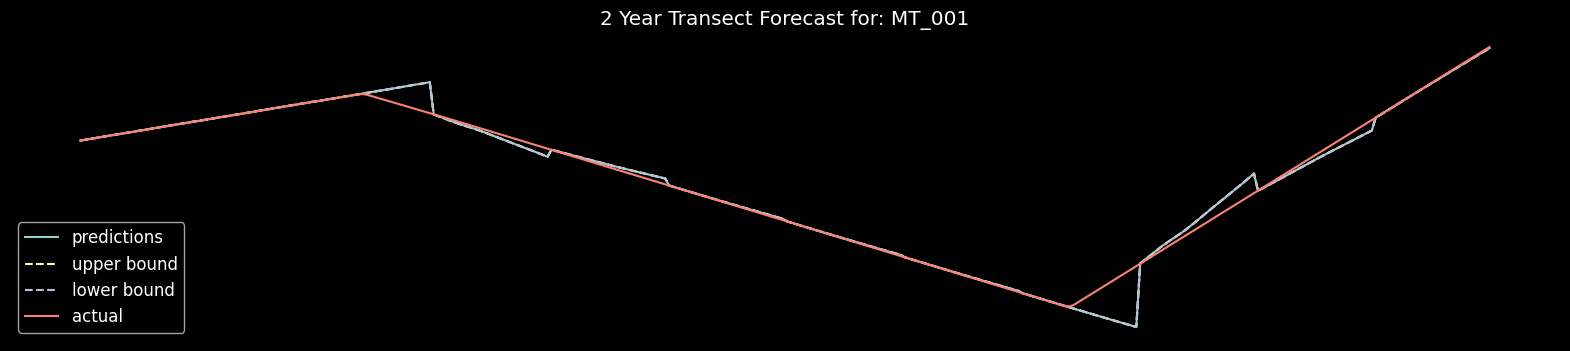

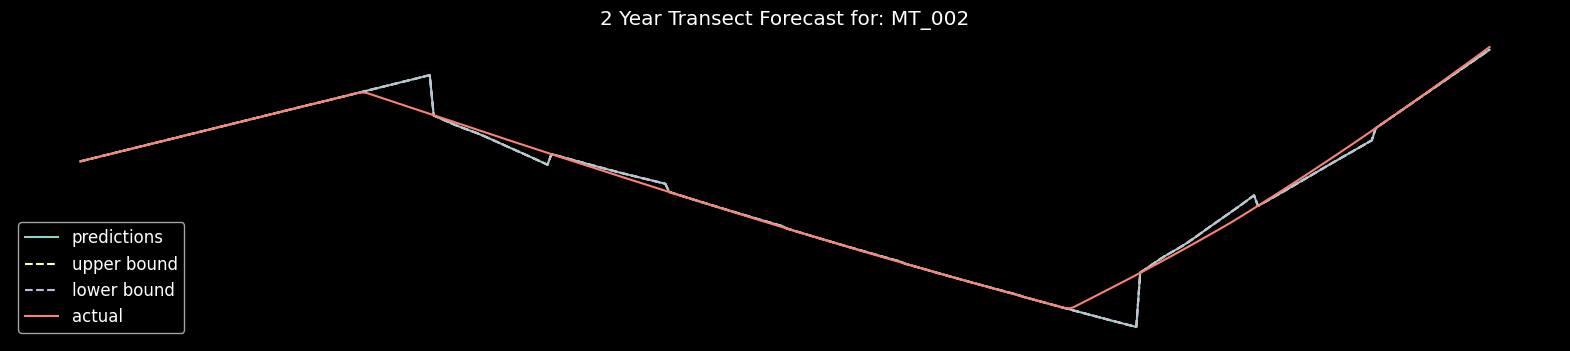

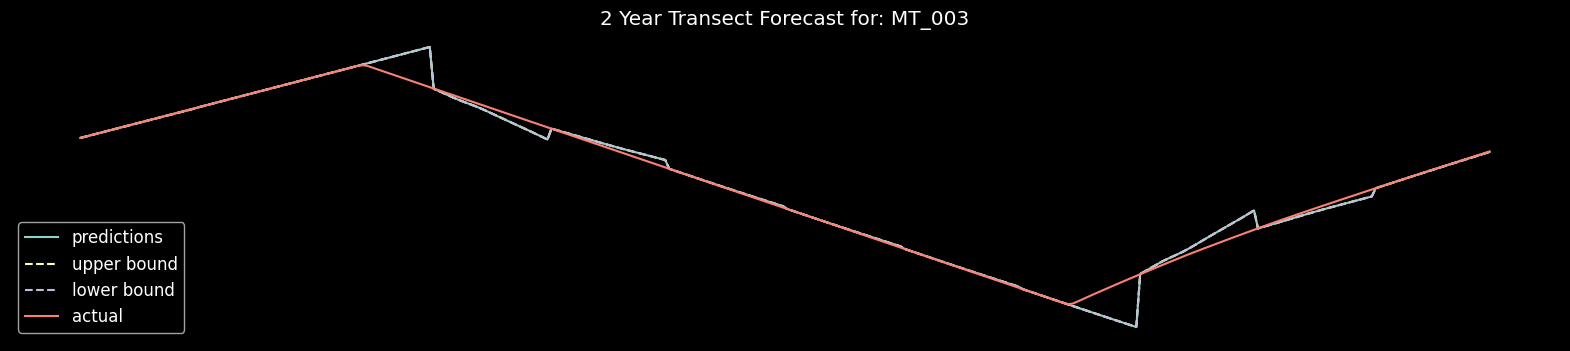

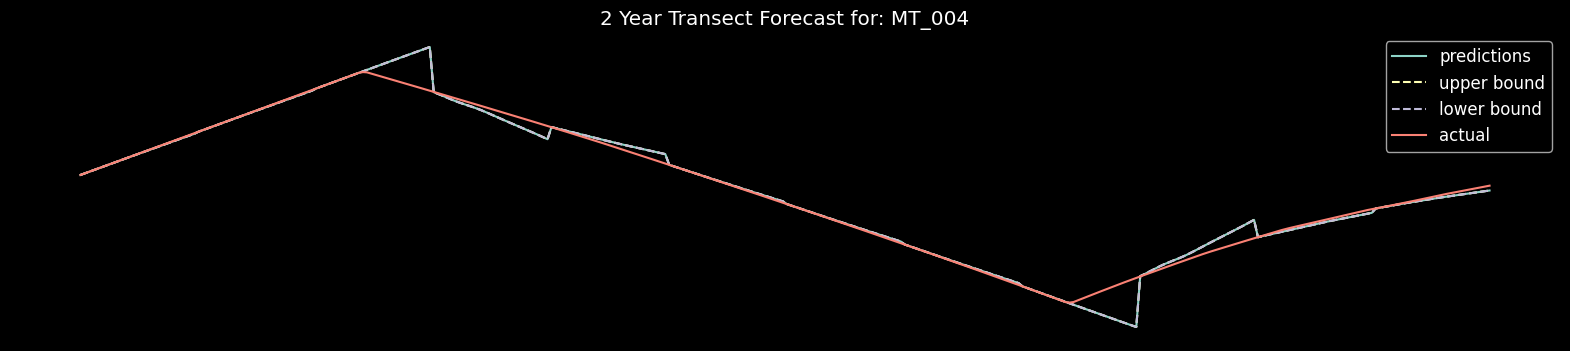

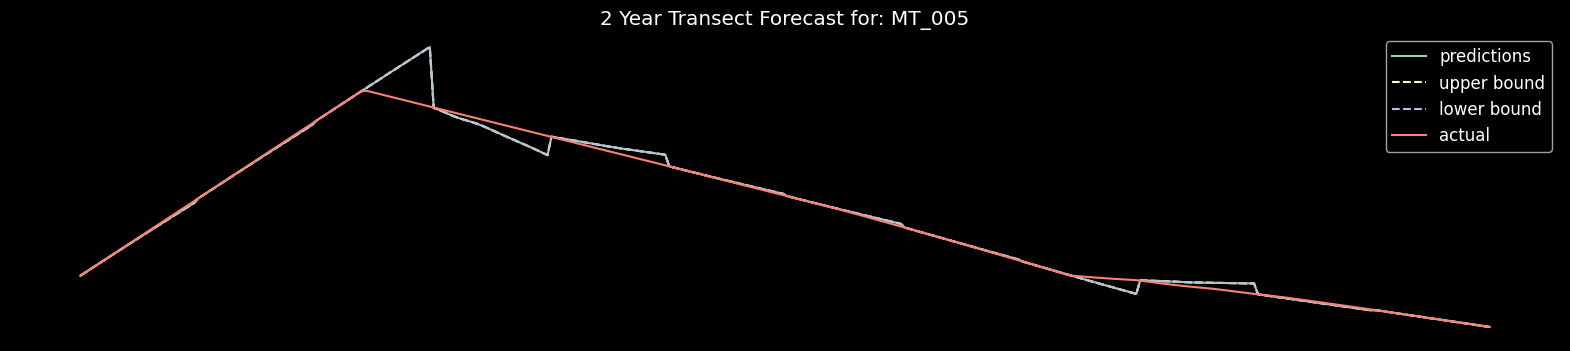

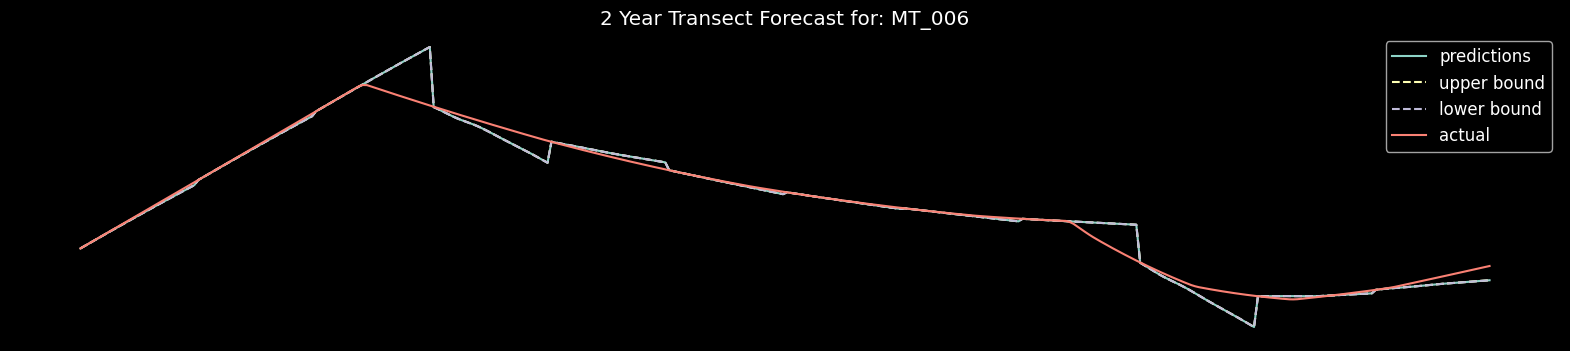

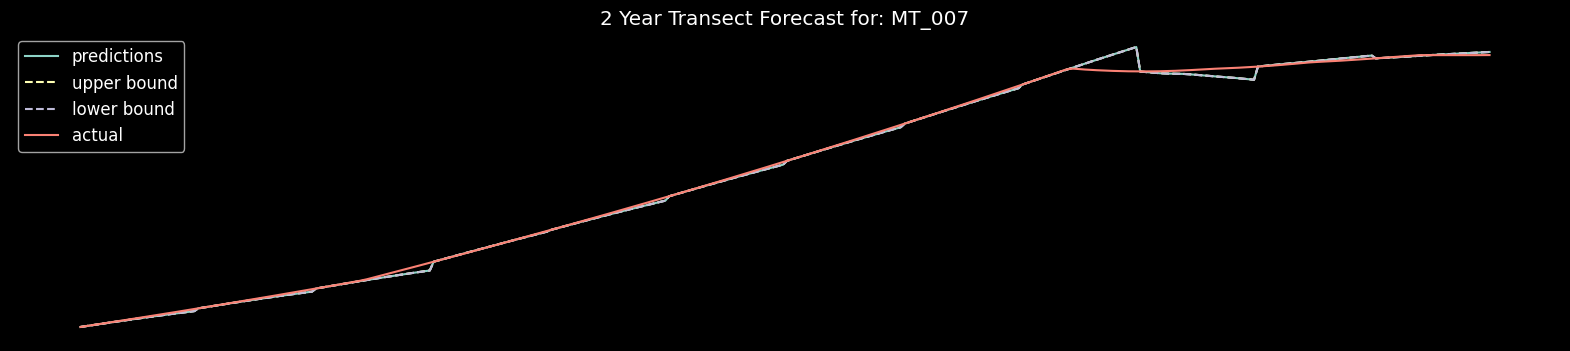

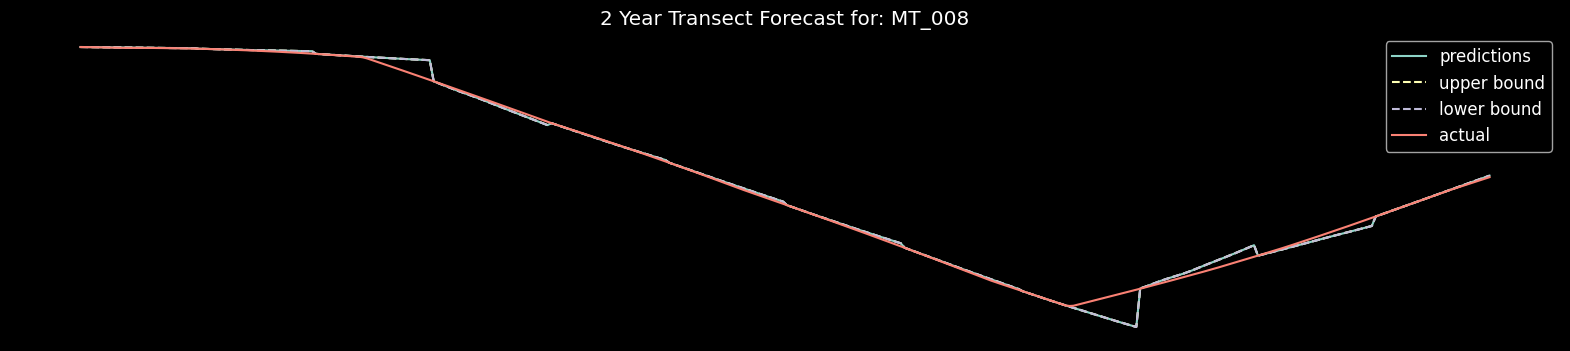

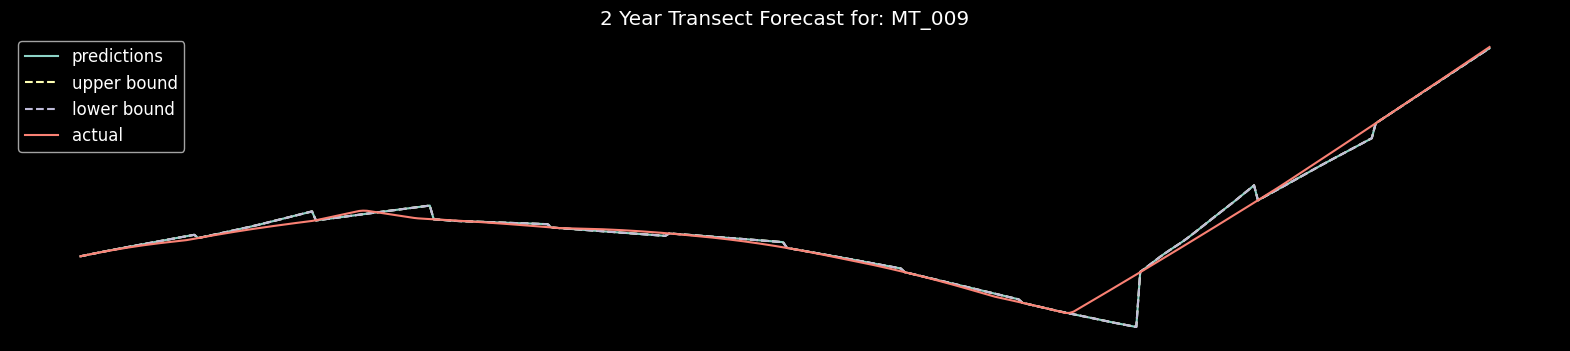

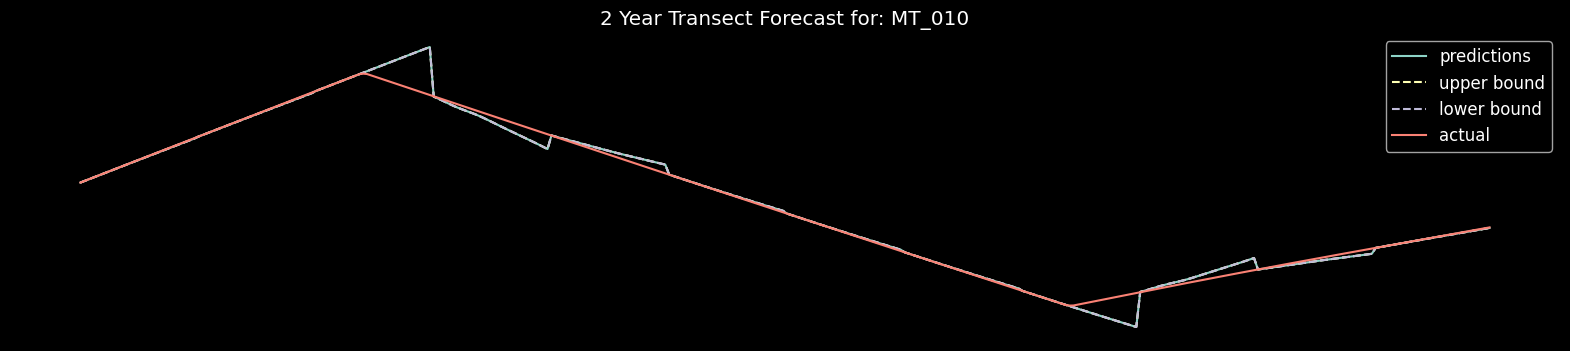

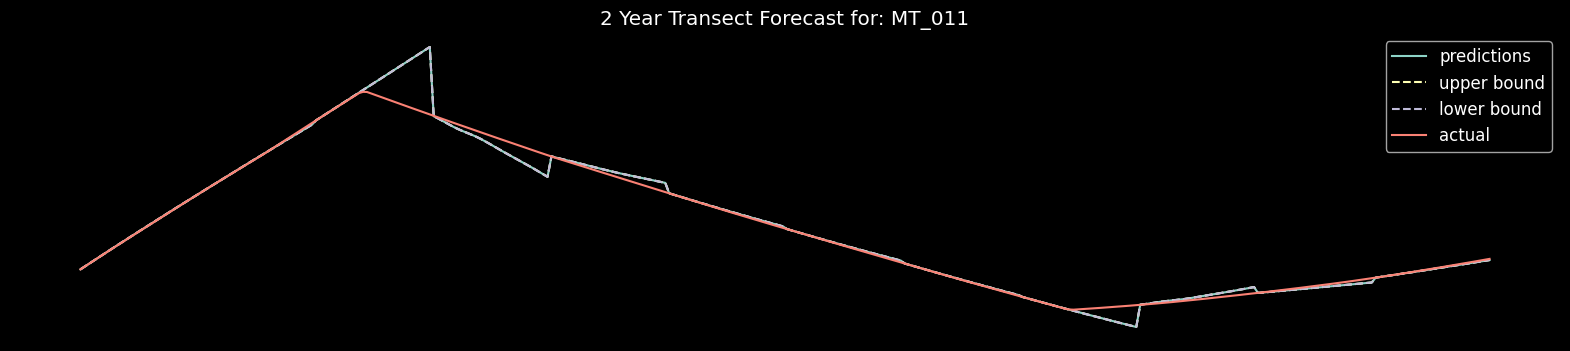

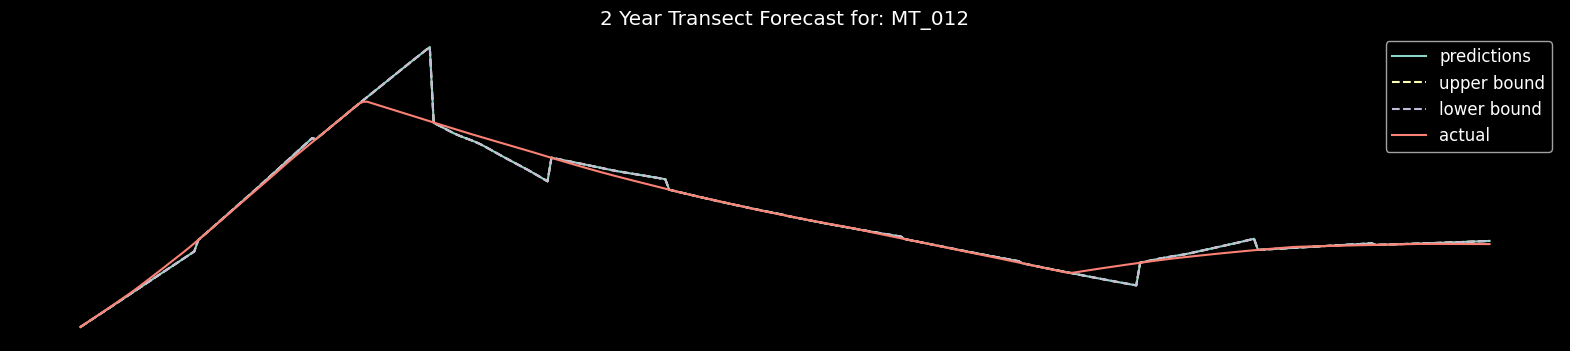

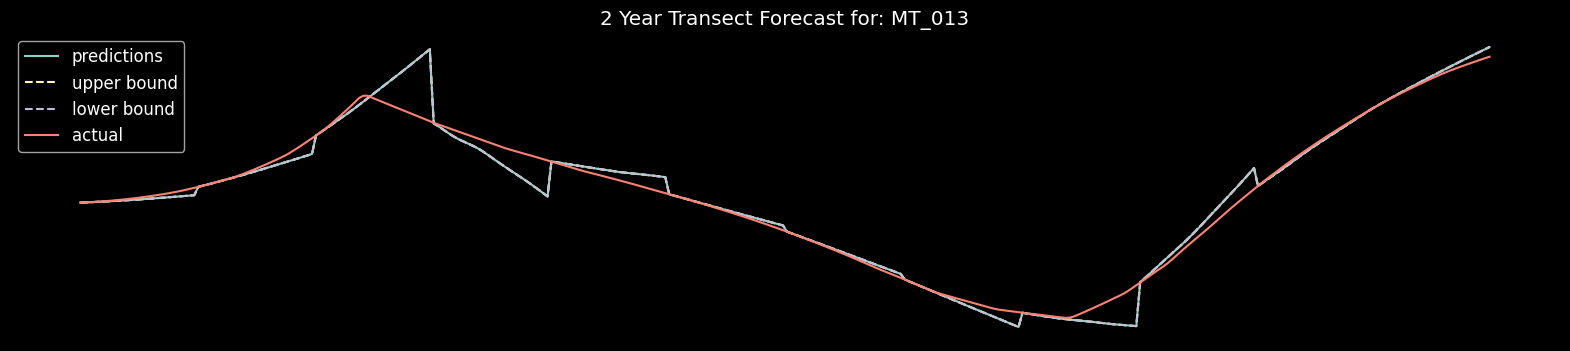

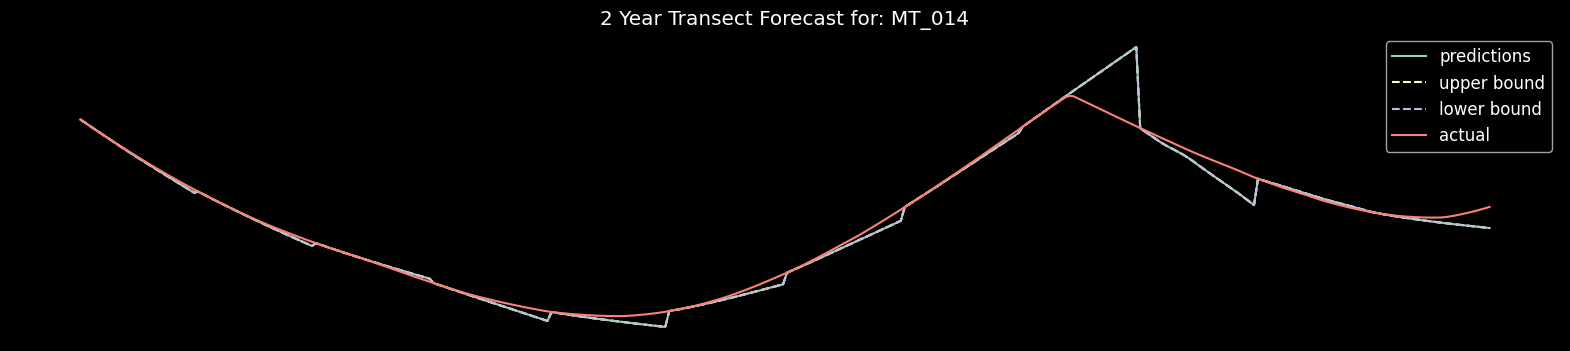

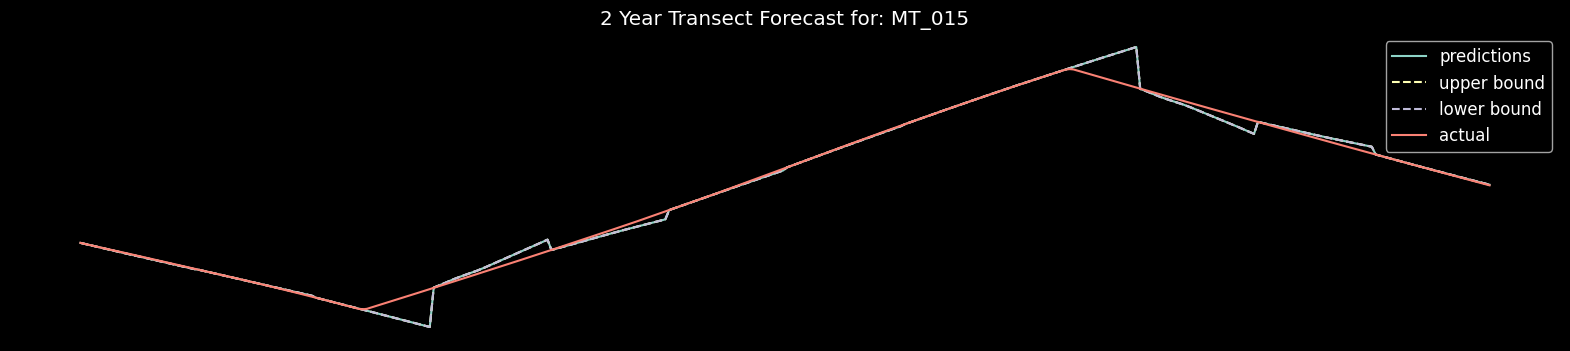

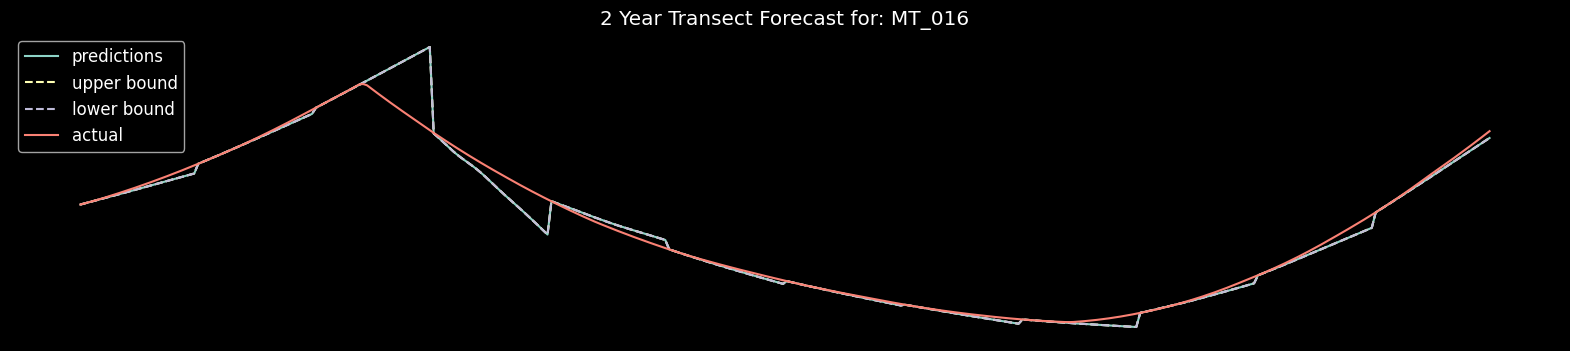

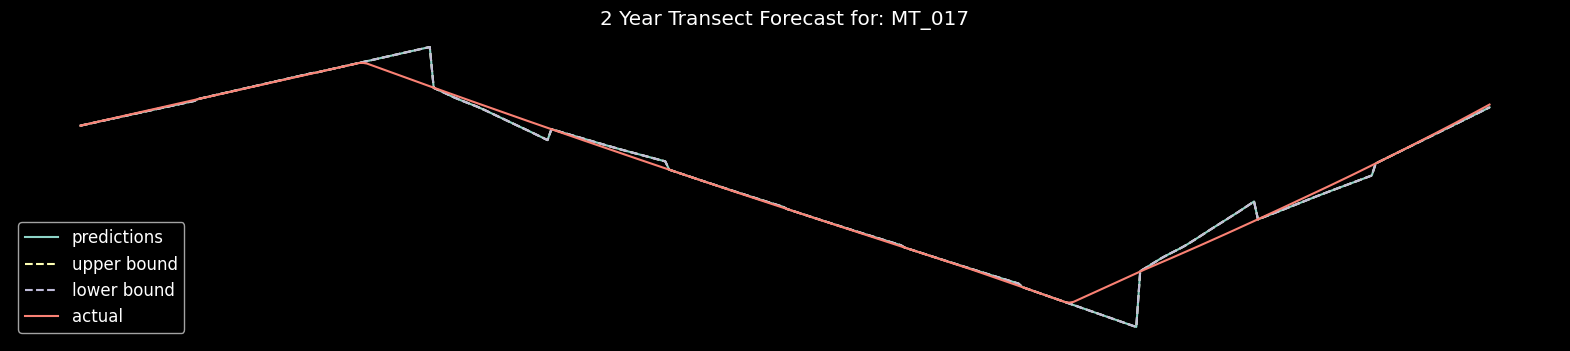

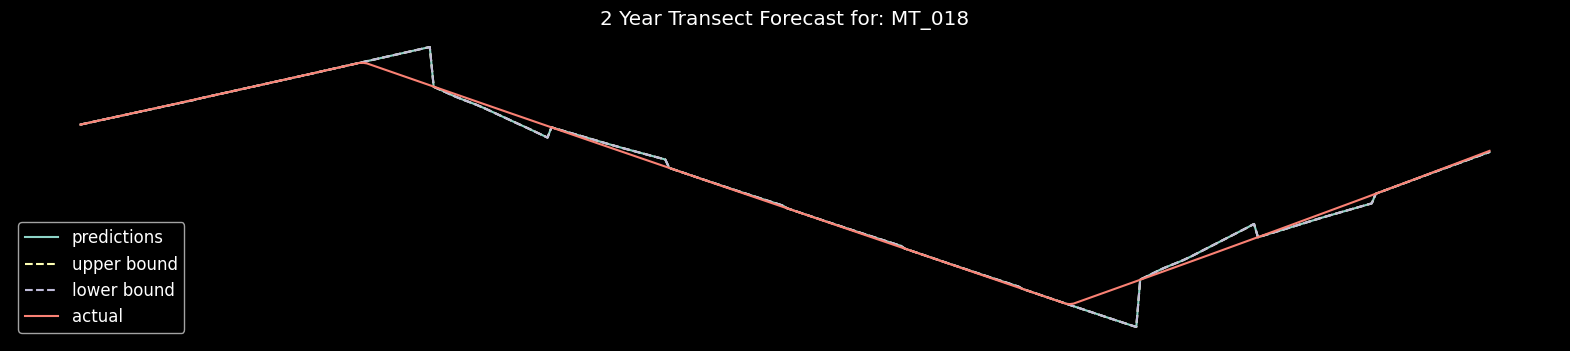

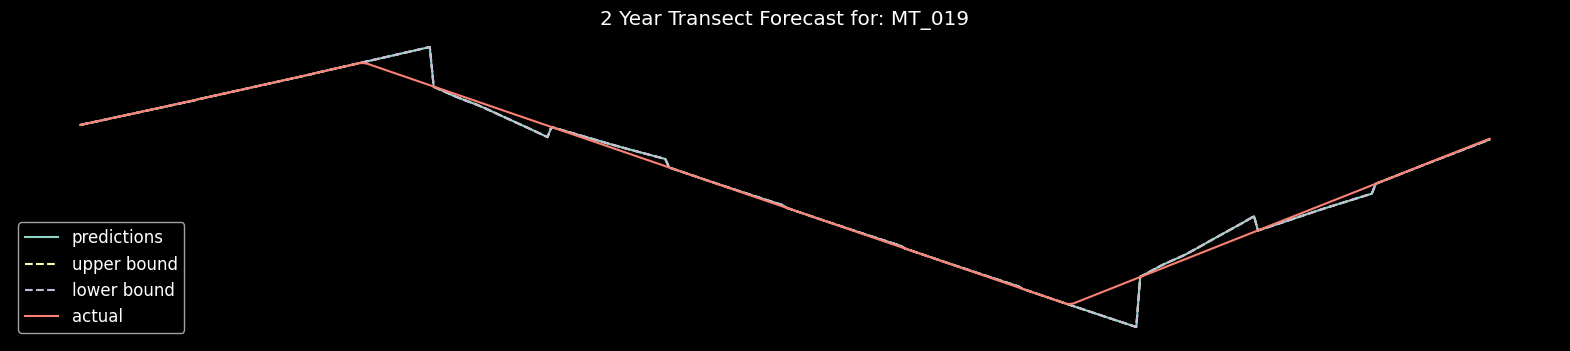

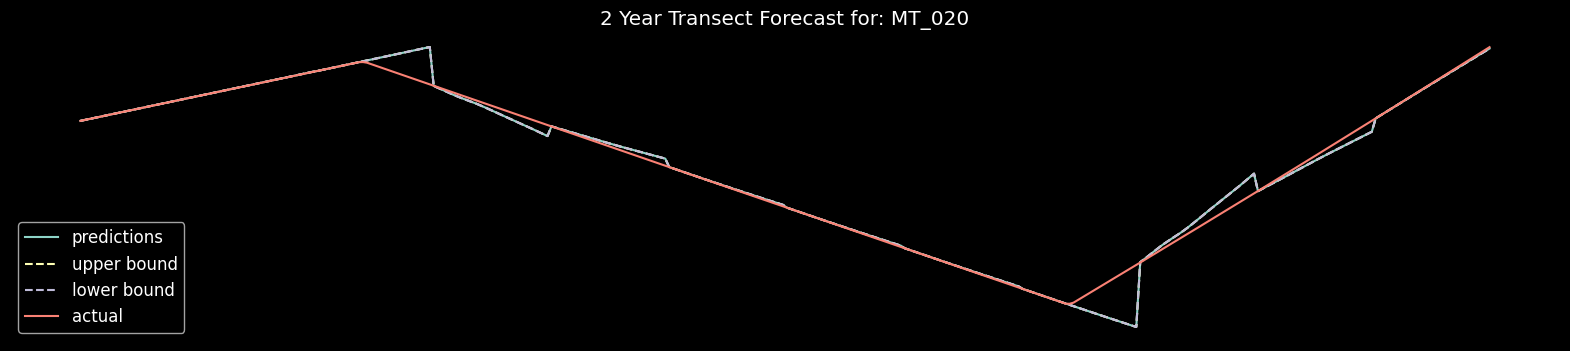

In [19]:
#setup visuals
%matplotlib inline
for i in range(20):
    #hide x and y axis ticks
    plt.rcParams['xtick.bottom'] = False
    plt.rcParams['ytick.left'] = False
    #hide labels
    plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['ytick.labelleft'] = False

    plt.figure()
    plt.title('2 Year Transect Forecast for: %s'%data_test.columns[i])
    plt.plot(predictions[i,:seasons*s_len],label= 'predictions')
    plt.plot(ub[i,:seasons*s_len],'--',label= 'upper bound')
    plt.plot(lb[i,:seasons*s_len],'--',label= 'lower bound')
    plt.plot(actual[:seasons*s_len,i],label = 'actual')
    plt.legend()
plt.show()

## export prediction

In [20]:
#write predictions to csv
dp = pd.DataFrame(predictions[:,:seasons*s_len].T, columns = data_test.columns)
dp.to_csv(table_name+'_pred.csv')

da = pd.DataFrame(actual[:seasons*s_len,:], columns = data_test.columns)
da.to_csv(table_name+'_act.csv')